# 2CSSID Lab03. Decision trees (DTs) and Ensemle Learning

<p style='text-align: right;font-style: italic;'>Designed by: Mr. Abdelkrime Aries</p>

In this lab, we will learn all about decision trees and ensemble learning.



**Team:**
- **Member 01**: DJEGHRI Lotfi
- **Member 02**: ARROUDJ Ilhem

In [56]:
import sys, timeit
from collections import OrderedDict
from typing          import Tuple, List, Type, Union
from collections.abc import Callable

sys.version

'3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]'

In [57]:
import numpy             as np
import pandas            as pd 
import matplotlib.pyplot as plt 
import matplotlib
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('2.1.2', '2.2.3', '3.9.2')

In [58]:
import sklearn

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.linear_model    import SGDClassifier
# from sklearn.multiclass      import OneVsRestClassifier
# from sklearn.multiclass      import OneVsOneClassifier
from sklearn.metrics         import accuracy_score
# from sklearn.metrics         import classification_report
# from sklearn.metrics         import log_loss

from   sklearn.tree    import DecisionTreeClassifier
from   sklearn.metrics import f1_score
from   sklearn         import tree
from   sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble     import BaggingClassifier
from sklearn.ensemble     import AdaBoostClassifier
from sklearn.ensemble     import StackingClassifier


sklearn.__version__

'1.5.2'

In [59]:
# This code is used to filter warnings concerning convergence
# In general, when the maximum number of iterations is not suffisant to converge
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [60]:
# !pip install graphviz
# Also you need to install the graphviz backend in the system
# Lien : https://graphviz.org/download/

## I. Algorithms implementation

In this section, we will try to implement ID3 and CART decision trees. 

In [61]:
# Dataset play 

# outlook & temperature & humidity & windy
Xplay_cat = np.array([
    ['sunny'   , 'hot' , 'high'  , 'no'],
    ['sunny'   , 'hot' , 'high'  , 'yes'],
    ['overcast', 'hot' , 'high'  , 'no'],
    ['rainy'   , 'mild', 'high'  , 'no'],
    ['rainy'   , 'cool', 'normal', 'no'],
    ['rainy'   , 'cool', 'normal', 'yes'],
    ['overcast', 'cool', 'normal', 'yes'],
    ['sunny'   , 'mild', 'high'  , 'no'],
    ['sunny'   , 'cool', 'normal', 'no'],
    ['rainy'   , 'mild', 'normal', 'no'],
    ['sunny'   , 'mild', 'normal', 'yes'],
    ['overcast', 'mild', 'high'  , 'yes'],
    ['overcast', 'hot' , 'normal', 'no'],
    ['rainy'   , 'mild', 'high'  , 'yes']
])

# temperature & humidity & windy
Xplay_num = np.array([
    [30, 85, 0],
    [27, 90, 1],
    [28, 78, 0],
    [21, 96, 0],
    [20, 80, 0],
    [18, 70, 1],
    [18, 65, 1],
    [22, 95, 0],
    [21, 70, 0],
    [24, 80, 0],
    [24, 70, 1],
    [22, 90, 1],
    [27, 75, 0],
    [22, 80, 1]
])


Yplay = np.array([
    'no', 
    'no', 
    'yes', 
    'yes', 
    'yes', 
    'no', 
    'yes', 
    'no', 
    'yes', 
    'yes', 
    'yes', 
    'yes', 
    'yes', 
    'no'
])

Xplay_cat.shape, Xplay_num.shape, Yplay.shape

((14, 4), (14, 3), (14,))

### I.1. Probability of a category

Given:
- $c$: a given nominal value (category)
- $A[M]$: values of a categorical attribute

the probability of this value is calculated as:

$$p(c \in A) = \frac{|\{a\, |\, a \in A \wedge a = c\}|}{|A|}$$


**>> P.S. If the division always returns 0, try applying float(x) on integer numbers**

In [62]:
# TODO: Probability of a category
def p_cat(c: str, A: 'np.ndarray[M](str)') -> float: 
    return np.count_nonzero( A == c ) / len( A )

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (0.6428571428571429,
#  0.35714285714285715,
#  0.2857142857142857,
#  0.35714285714285715)
#---------------------------------------------------------------------

p_cat('yes'     , Yplay      ), \
p_cat('sunny'   , Xplay_cat[:, 0]), \
p_cat('overcast', Xplay_cat[:, 0]), \
p_cat('rainy'   , Xplay_cat[:, 0])

(0.6428571428571429,
 0.35714285714285715,
 0.2857142857142857,
 0.35714285714285715)

### I.2. Homogeneity of a set


#### I.2.1. Shannon's entropy

Given:
- $A[M]$: values of a categorical attribute
- $V$: a set of unique categories of $A$ (vocabulary) 

Shannon's entropy is calculated as: 
$$H(A) = - \sum\limits_{c \in V} p(c \in A) \log_2 p(c \in A)$$


**>> P.S. np.log2 calculate log2 of a scalar, vector or matrix**

In [63]:
# TODO: Shannon's entropy
def shannon_entropy(A: 'np.ndarray[M](str)') -> float: 
    return -np.sum( [ p_cat(c, A) * np.log2( p_cat( c, A ) ) for c in np.unique( A ) ] )  

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (0.9402859586706311, 1.5774062828523454, 1.5566567074628228)
#---------------------------------------------------------------------

shannon_entropy(Yplay), \
shannon_entropy(Xplay_cat[:, 0]), \
shannon_entropy(Xplay_cat[:, 1])

(np.float64(0.9402859586706311),
 np.float64(1.5774062828523454),
 np.float64(1.5566567074628228))

#### I.2.2. Gini diversity index (Gini impurity)

Given:
- $A[M]$: values of a categorical attribute
- $V$: a set of unique categories of $A$ (vocabulary) 

Gini impurity is calculated by: 
$$Gini(A) = \sum\limits_{c \in V} p(c \in A) (1-p(c \in A)) = 1 - \sum\limits_{c \in V} p(c \in A)^2 $$

In [64]:
# TODO: Gini impurity
def gini_impurity(A: 'np.ndarray[M](str)') -> float:  
    return 1 - np.sum( [ p_cat(c, A) ** 2 for c in np.unique(A) ] )  

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# 0.4591836734693877
#---------------------------------------------------------------------

gini_impurity(Yplay)

np.float64(0.4591836734693877)

### I.3. Set splitting

**>> Nothing to code here**

#### I.3.1. ID3's set splitting

Given:
- $Y[M]$: values of the output attribute,
- $A[M]$: values of a categorical attribute,
- $c$: a given nominal value (category) of $A$;

$Y$ is split as:
$$Y_{c \in A} = \{y^{(i)} \in Y\, |\, a^{(i)} \in A \wedge a^{(i)} = c\}$$


In [65]:
def split_ID3(c: str, 
              A: 'np.ndarray[M](str)', 
              Y: 'np.ndarray[M](str)'
              ) -> 'np.ndarray(str)':
    msk = A == c
    return Y[msk]

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# array(['no', 'no', 'no', 'yes', 'yes'], dtype='<U3')
#---------------------------------------------------------------------

split_ID3('sunny', Xplay_cat[:,0], Yplay)

array(['no', 'no', 'no', 'yes', 'yes'], dtype='<U3')

#### I.3.2. CART's set splitting

Given:
- $Y[M]$: values of the output attribute,
- $A[M]$: values of a numerical attribute,
- $v$: a given numerical value of $A$;


$Y$ is split as:
- $Y_L$: a subset of $Y$ where $A > v$
- $Y_R$: a subset of $Y$ where $A \le v$

In [66]:
def split_CART(v: float,
               A: 'np.ndarray[M](float)',
               Y: 'np.ndarray[M](str)'
               ) -> Tuple['np.ndarray(str)', 'np.ndarray(str)']:
    msk = A > v
    return Y[msk], Y[~msk]

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (array(['no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
#         'no'], dtype='<U3'),
#  array(['yes', 'no', 'yes'], dtype='<U3'))
#---------------------------------------------------------------------

split_CART(20, Xplay_num[:,0], Yplay)

(array(['no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
        'no'], dtype='<U3'),
 array(['yes', 'no', 'yes'], dtype='<U3'))

### I.4. Choice of split feature

#### I.4.1. Information gain

Given:
- $Y[M]$: values of the output attribute,
- $A[M]$: values of a numerical attribute,
- $V$: a set of unique categories of $A$ (vocabulary),

Informtion gain is calculated as: 
$$IG(A, Y) = H(Y) - \sum_{c \in V} p(c \in A) H(Y_{c \in A})$$

**>> The function must return a tuple (Information gain, entropy)**

In [67]:
# TODO: Information gain
def information_gain(A: 'np.ndarray[M](str)',
                     Y: 'np.ndarray[M](str)'  
                     ) -> Tuple[float, float]:
    h  = shannon_entropy(Y)
    ig = h
    # Complete here
    ig = h - np.sum([p_cat(c, A) * shannon_entropy( split_ID3(c, A, Y) ) for c in np.unique(A)])  
    
    return ig, h

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# ((0.24674981977443933, 0.9402859586706311),
#  (0.02922256565895487, 0.9402859586706311),
#  (0.15183550136234164, 0.9402859586706311),
#  (0.048127030408269544, 0.9402859586706311))
#---------------------------------------------------------------------

information_gain(Xplay_cat[:, 0], Yplay),\
information_gain(Xplay_cat[:, 1], Yplay),\
information_gain(Xplay_cat[:, 2], Yplay),\
information_gain(Xplay_cat[:, 3], Yplay)

((np.float64(0.24674981977443933), np.float64(0.9402859586706311)),
 (np.float64(0.02922256565895487), np.float64(0.9402859586706311)),
 (np.float64(0.15183550136234159), np.float64(0.9402859586706311)),
 (np.float64(0.04812703040826949), np.float64(0.9402859586706311)))

#### I.4.2. Gini impurity of the split

Given: 
- $Y[M]$: values of the output attribute,
- $Y_L, Y_R$: to subsets of $Y$ where $Y_L \cup Y_R = Y$;

Gini impurity of the split is calculated as: 

$$Gini_{split}(Y_L, Y_R) = \frac{|Y_L|}{|Y|} Gini(Y_L) + \frac{|Y_R|}{|Y|} Gini(S_R)$$


In [68]:
# TODO: Gini impurity of the split
def gini_split(Y_L: 'np.ndarray(str)', Y_R: 'np.ndarray(str)') -> float:  
    return len(Y_L) * gini_impurity(Y_L) / (len(Y_L) + len(Y_R)) + len(Y_R) * gini_impurity(Y_R) / (len(Y_L) + len(Y_R) )

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# 0.4588744588744589
#---------------------------------------------------------------------

gini_split(*split_CART(20, Xplay_num[:, 0], Yplay))

np.float64(0.4588744588744589)

### I.5. Splitting feature selection

#### I.5.1. ID3 splitting feature selection

Given:
- $X[M, N]$: a matrix of $M$ samples and $N$ categorical features,
- $Y[M]$: a vector of output labels;

We want to find the feature which maximizes:

$$\hat{j} = \arg\max_j IG(Y, X_j)$$

This function must return:
- $\hat{j}$: the index of the best feature
- $IG(Y, X_{\hat{j}})$: its information gain
- $H(Y)$: the entropy

In [69]:
# TODO: ID3 splitting feature selection
def choose_split_ID3(X: 'np.ndarray[M, N](str)', 
                     Y: 'np.ndarray[Y](str)'
                     ) -> Tuple[int, float, float]: 
    bestj    = -1   # number of the best feature
    ig_bestj = -1.0 # IG of the best feature
    h_bestj  = -1.0 # Entropy of the best feature
    # Complete here
    for j in range( X.shape[1] ):
        ig, h = information_gain( X[:, j], Y )
        if ig > ig_bestj:
            bestj, ig_bestj, h_bestj = j, ig, h

    return bestj, ig_bestj, h_bestj

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (0, 0.24674981977443933, 0.9402859586706311)
#---------------------------------------------------------------------

choose_split_ID3(Xplay_cat, Yplay)

(0, np.float64(0.24674981977443933), np.float64(0.9402859586706311))

#### I.5.2. CART splitting feature and value selection

Given:
- $X[M, N]$: a matrix of $M$ samples and $N$ categorical features,
- $Y[M]$: a vector of output labels;

We want to find the feature and its value which minimize Gini impurity for the split.

Algorithm:
- For each feature $X_j$ 
   - For each value $v \in unique(X_j)$
       1. Split $Y$ given $X_j$ and $v$
       1. Calculate Gini diversity of the division
       1. If its value is less than the last one, save it along with $j$ as $\hat{j}$, $v$ as $\hat{v}$

This function must return:
- $\hat{j}$: the index of the best feature
- $\hat{v}$: the value of the best feature
- $Gini_{split}/\hat{j}, \hat{v}$: the split Gini based on the best feature and its value

In [70]:
# TODO: CART splitting feature and value selection
def choose_split_CART(X: 'np.ndarray[M, N](float)', 
                      Y: 'np.ndarray[Y](str)'
                      ) -> Tuple[int, float, float]:
    bestj      = -1
    gini_bestj =  1.0
    v_bestj    = -1.0
    # Complete here
    for j in range(X.shape[1]):
        for v in np.unique(X[:, j]):
            Y_L, Y_R = split_CART(v, X[:, j], Y)
            gini = gini_split(Y_L, Y_R)
            if gini < gini_bestj:
                bestj, v_bestj, gini_bestj = j, v, gini
    return bestj, v_bestj, gini_bestj

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (1, 80, 0.3936507936507937)
#---------------------------------------------------------------------

choose_split_CART(Xplay_num, Yplay)

(1, np.int64(80), np.float64(0.3936507936507936))

### I.6. Stopping criterion

Given:
- $Y$: a set of outupt labels in a given node
- $h$: the homogeneity criterion. h = 0 ==> the set Y is homogeneous (same values)
- $nbr\_min$: the minimum number of samples in a node. |Y| <= nbr_min ==> the node must be a leaf

the function must return:
- The name of the class: if the set is homogeneous or it contains a minimum number of elements
- None: otherwise

**>> HINT: use numpy.unique and numpy.argmax**

In [71]:
# TODO: Stopping criterion
def stop(Y: np.ndarray, h: float, nbr_min: int) -> Union[str, None]:
    if len(Y) <= nbr_min or h == 0:
        return 'yes' if np.count_nonzero(Y == 'yes') > np.count_nonzero(Y == 'no') else 'no'    
   
#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# ('yes', 'no', None, 'yes', 'no', None)
#---------------------------------------------------------------------

Y_t1 = np.array(['yes', 'yes', 'yes'])
Y_t2 = np.array(['yes', 'no', 'no'])

stop(Y_t1, shannon_entropy(Y_t1), 2), \
stop(Y_t2, shannon_entropy(Y_t2), 4), \
stop(Y_t2, shannon_entropy(Y_t2), 2), \
stop(Y_t1, gini_impurity(Y_t1), 2), \
stop(Y_t2, gini_impurity(Y_t2), 4), \
stop(Y_t2, gini_impurity(Y_t2), 2)

('yes', 'no', None, 'yes', 'no', None)

### I.7. Final product

**>> Nothing to code here**

#### I.7.1. Tree structure and prediction

In [72]:
# A class to represent a node
class Node(object): 
    
    nbr = 0
    
    def __init__(self, test: Union[int, Tuple[int, float]], depth:int=0, info:str=''): 
        self.test     = test          # test creteria the number of the feature (+ the value)
        self.depth    = depth         # the depth of the noade
        self.children = OrderedDict() # the children: a dictionary of value: node
        self.cls      = ''            # the class if the node is a leaf
        self.indent   = '    '        # indentation hen generating the code
        self.info     = info
    
    # Transform the node to a string
    def __str__(self):
        
        indent = self.indent * self.depth # indentation
        
        # if no children, the node is a leaf; print the class
        if (len(self.children) == 0):
            return indent + 'return "' + self.cls + '"\n'
        
        if isinstance(self.test, int):
            tst1, tst3 = str(self.test) + '] == "', '"'
        else:
            tst1, tst3 = str(self.test[0]) + '] ', ''
        tst1 = 'if X[' + tst1

        # if there are children, print IF conditions
        i, l = 0, len(self.children) - 1
        res = ""
        for f_v, n_v in self.children.items():
            tst2 = str(f_v)
            if i == l:
                tst1, tst2, tst3 = 'else', '', ''
            elif i > 0:
                tst1 = 'el' + tst1
            res += indent + tst1 + tst2 + tst3 + ':\n' + str(n_v)
            i += 1
            
        return res
    
    # predict a sample
    def predict(self, x: List[str]) -> str: 
        
        # If the node is final, return its class
        if (len(self.children) == 0):
            return self.cls
        
        # ID3
        if isinstance(self.test, int):
            # If the value of this node's feature is not in its children
            # return np.nan
            if x[self.test] not in self.children: 
                return np.nan
        
            # Otherwise, it returns the prediction of the child
            return self.children[x[self.test]].predict(x)
        
        # CART
        if x[self.test[0]] > self.test[1]:
            return self.children.items[0][1].predict(x)
        return self.children.items[1][1].predict(x)
        
    def graphviz(self): 
        
        nid = 'N' + str(Node.nbr)
        Node.nbr += 1
        
        if (len(self.children) == 0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        
        j = self.test if isinstance(self.test, int) else self.test[0]
        
        res  = nid + '[label="X[' + str(j) + ']\\n'
        res += self.info
        for f in self.children:
            vid, code = self.children[f].graphviz()
            res += code
            res += nid + ' -> ' + vid + ' [label="' + f + '"];\n'
        return nid, res
    
#=====================================================================
# UNIT TEST
#=====================================================================
# The code
# 'return "c1"\n'
#---------------------------------------------------------------------

nn = Node(test=5)
nn.cls = 'c1'
str(nn)

'return "c1"\n'

#### I.7.2. Tree construction (training)

In [73]:
def fit_ID3(X: 'np.ndarray[M, N]', 
            Y: 'np.ndarray[M]', 
            nbr_min: int = 0, 
            depth : int = 0
            ) -> Node: 
    
    j, ig, h = choose_split_ID3(X, Y)
    info = 'H = {:.5f}\\nIG = {:.5f}"];\n'.format(h, ig)
    node = Node(j, depth=depth, info=info)
    c = stop(Y, h, nbr_min)
    if c:
        node.cls = c 
        return node 

    depth += 1 
    for v in np.unique(X[:, j]):
        msk = X[:, j] == v 
        X_v = X[msk]
        Y_v = Y[msk]
        child = fit_ID3(X_v, Y_v, nbr_min=nbr_min, depth=depth)
        node.children[v] = child
    
    return node

#=====================================================================
# UNIT TEST
#=====================================================================
# The code
# if X[0] == "overcast":
#     return "yes"
# elif X[0] == "rainy":
#     if X[3] == "no":
#         return "yes"
#     else:
#         return "no"
# else:
#     if X[2] == "high":
#         return "no"
#     else:
#         return "yes"

# 'yes'
#---------------------------------------------------------------------

tree_cat = fit_ID3(Xplay_cat, Yplay)

print('The code')
print(tree_cat)

# Test a sample
tree_cat.predict(['rainy', 'temperature_makanche', 'humidity_makanche', 'no'])

The code
if X[0] == "overcast":
    return "yes"
elif X[0] == "rainy":
    if X[3] == "no":
        return "yes"
    else:
        return "no"
else:
    if X[2] == "high":
        return "no"
    else:
        return "yes"



'yes'

In [74]:
def fit_CART(X: 'np.ndarray[M, N]', 
             Y: 'np.ndarray[M]', 
             nbr_min: int = 0, 
             depth : int = 0
             ) -> Node:  
    
    j, v, gini = choose_split_CART(X, Y)
    info = 'Gini = {:.5f}"];\n'.format(gini)
    node = Node((j, v), depth=depth, info=info)

    c = stop(Y, gini, nbr_min)
    if c:
        node.cls = c 
        return node 
     
    depth += 1 
    
    msk = X[:, j] > v
    
    X_L = X[msk]
    Y_L = Y[msk]
    child_L = fit_CART(X_L, Y_L, nbr_min=nbr_min, depth=depth)
    X_R = X[~msk]
    Y_R = Y[~msk]
    child_R = fit_CART(X_R, Y_R, nbr_min=nbr_min, depth=depth)
    node.children['> ' + str(v)] = child_L
    node.children['<= ' + str(v)] = child_R
    
    return node

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# The Code
# if X[1] > 80:
#     if X[0] > 22:
#         return "no"
#     else:
#         if X[0] > 21:
#             return "no"
#         else:
#             return "yes"
# else:
#     if X[2] > 0:
#         if X[1] > 70:
#             return "no"
#         else:
#             if X[0] > 18:
#                 return "yes"
#             else:
#                 return "no"
#     else:
#         return "yes"
#---------------------------------------------------------------------

tree_num = fit_CART(Xplay_num, Yplay)

print('The Code')
print(tree_num)

The Code
if X[1] > 80:
    if X[0] > 22:
        return "no"
    else:
        if X[0] > 21:
            return "no"
        else:
            return "yes"
else:
    if X[2] > 0:
        if X[0] > 22:
            return "yes"
        else:
            return "no"
    else:
        return "yes"



#### I.7.3. Decision tree class

In [75]:
class DT(object): 

    def __init__(self, num=False):
        if num:
            self.fit_fct = fit_CART
        else:
            self.fit_fct = fit_ID3
    
    def fit(self, 
            X: 'np.ndarray[M, N]', 
            Y: 'np.ndarray[M]', 
            features: List[str] = [], 
            clsname:str = '', 
            nbr_min:int = 0):
        
        self.tree = self.fit_fct(X, Y, nbr_min=nbr_min, depth=0)
        code = str(self.tree)
        if len(clsname) > 0: 
            code = code.replace('Y', clsname)
        for i in range(len(features)): 
            code = code.replace('X[' + str(i) + ']', features[i])
        self.code   = code
        self.features = features
    
    def predict(self, x:np.ndarray): 
        predictions = []
        for i in range(len(x)): 
            predictions.append(self.tree.predict(x[i, :]))
        return predictions
    
    def graphviz(self): 
        nid, code = self.tree.graphviz()
        res  = 'digraph Tree {\n'
        res += 'node [shape=box] ;'
        for i in range(len(self.features)): 
            code = code.replace('X[' + str(i) + ']', self.features[i])
        res += code
        res += '}'
        return res
    
#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# ID3
# -------------
# if outlook == "overcast":
#     return "yes"
# elif outlook == "rainy":
#     if windy == "no":
#         return "yes"
#     else:
#         return "no"
# else:
#     if humidity == "high":
#         return "no"
#     else:
#         return "yes"

# CART
# -------------
# if temperature > 80:
#     if outlook > 22:
#         return "no"
#     else:
#         if outlook > 21:
#             return "no"
#         else:
#             return "yes"
# else:
#     if humidity > 0:
#         if temperature > 70:
#             return "no"
#         else:
#             if outlook > 18:
#                 return "yes"
#             else:
#                 return "no"
#     else:
#         return "yes"
#---------------------------------------------------------------------

features=['outlook', 'temperature', 'humidity', 'windy']

id3_classifier = DT()
id3_classifier.fit(Xplay_cat, Yplay, features=features, clsname='play')

cart_classifier = DT(num=True)
cart_classifier.fit(Xplay_num, Yplay, features=features, clsname='play')

print('ID3')
print('-------------')
print(id3_classifier.code)
print('CART')
print('-------------')
print(cart_classifier.code)

ID3
-------------
if outlook == "overcast":
    return "yes"
elif outlook == "rainy":
    if windy == "no":
        return "yes"
    else:
        return "no"
else:
    if humidity == "high":
        return "no"
    else:
        return "yes"

CART
-------------
if temperature > 80:
    if outlook > 22:
        return "no"
    else:
        if outlook > 21:
            return "no"
        else:
            return "yes"
else:
    if humidity > 0:
        if outlook > 22:
            return "yes"
        else:
            return "no"
    else:
        return "yes"



In [76]:
# It's just a visualization of the graph
# If it doesn't work, it doesn't matter
try:
    from IPython.display import SVG
    from graphviz        import Source
    from IPython.display import display
    
    graph = Source(id3_classifier.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print('You have to install graphviz: https://graphviz.org/download/')

You have to install graphviz: https://graphviz.org/download/


In [77]:
# It's just a visualization of the graph
# If it doesn't work, it doesn't matter
try:
    from IPython.display import SVG
    from graphviz        import Source
    from IPython.display import display
    
    graph = Source(cart_classifier.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print('You have to install graphviz: https://graphviz.org/download/')

You have to install graphviz: https://graphviz.org/download/


## II. Application and Analysis

In this section, we will test different concepts by running an experiment, formulating a hypothesis and trying to justify it. 
We will use [Cars Data](https://www.kaggle.com/abineshkumark/carsdata) just for 3 classes: US., Euroupe. and Japan. 

In [78]:
# Dataset import
cars_data = pd.read_csv('data/cars.csv', skipinitialspace=True)
# Remove missing values
cars_data.dropna(inplace=True)
# Yay! We did it! These are the first samples
cars_data.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350.0,165,4209.0,12,1972,US.
1,31.9,4,89.0,71,1925.0,14,1980,Europe.
2,17.0,8,302.0,140,3449.0,11,1971,US.
3,15.0,8,400.0,150,3761.0,10,1971,US.
4,30.5,4,98.0,63,2051.0,17,1978,US.


In [79]:
cars_data.dtypes

mpg            float64
cylinders        int64
cubicinches    float64
hp               int64
weightlbs      float64
time-to-60       int64
year             int64
brand           object
dtype: object

In [80]:
X_cars = cars_data.values[:, :-1]
Y_cars = cars_data.values[:,  -1]

X_cars_train, X_cars_test, Y_cars_train, Y_cars_test = train_test_split(X_cars, 
                                                                        Y_cars, 
                                                                        test_size=0.2, 
                                                                        random_state=0) 

X_cars_train.shape, X_cars_test.shape

((204, 7), (52, 7))

### II.1. Decision trees and Random forests

We want to test the effect of different hyper-parameters of decision trees.


In Scikit-learn's implemtation (**DecisionTreeClassifier**), features are always randomly permuted at each split.
The tree will be undeterministic (which is good for overfitting, but not good for tessting the effect of hyper-parameters).
In this case, we stop this property using **random_state=0**.

#### II.1.1. Feature selection criteria

In scikit-learn, there is only CART which can use both: 
1. Entropy
1. Gini

Both will generate slightly different decision tree structures. We want to test the effect of the structure on training and test.

In [81]:
Xtrain = X_cars_train
Ytrain = Y_cars_train
Xtest  = X_cars_test
Ytest  = Y_cars_test
fnames = cars_data.columns


gini_stats         = []
entropy_stats      = []
gini_classifier    = DecisionTreeClassifier(criterion='gini'   , random_state=0, min_samples_leaf=7)
entropy_classifier = DecisionTreeClassifier(criterion='entropy', random_state=0, min_samples_leaf=7)

# ============ GINI ====================
# ................ Train ..............
temps_debut = timeit.default_timer()
gini_classifier.fit(Xtrain, Ytrain)
gini_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation train .........
gini_stats.append(f1_score(Ytrain, gini_classifier.predict(Xtrain), average='micro'))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = gini_classifier.predict(Xtest)
gini_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
gini_stats.append(f1_score(Ytest, Ychoix_pred, average='micro'))

# =========== Entropy ==================
# ............ Train ............
temps_debut = timeit.default_timer()
entropy_classifier.fit(Xtrain, Ytrain)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation train ........
entropy_stats.append(f1_score(Ytrain, entropy_classifier.predict(Xtrain), average='micro'))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = entropy_classifier.predict(Xtest)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
entropy_stats.append(f1_score(Ytest, Ychoix_pred, average='micro'))

print('Fin')

Fin


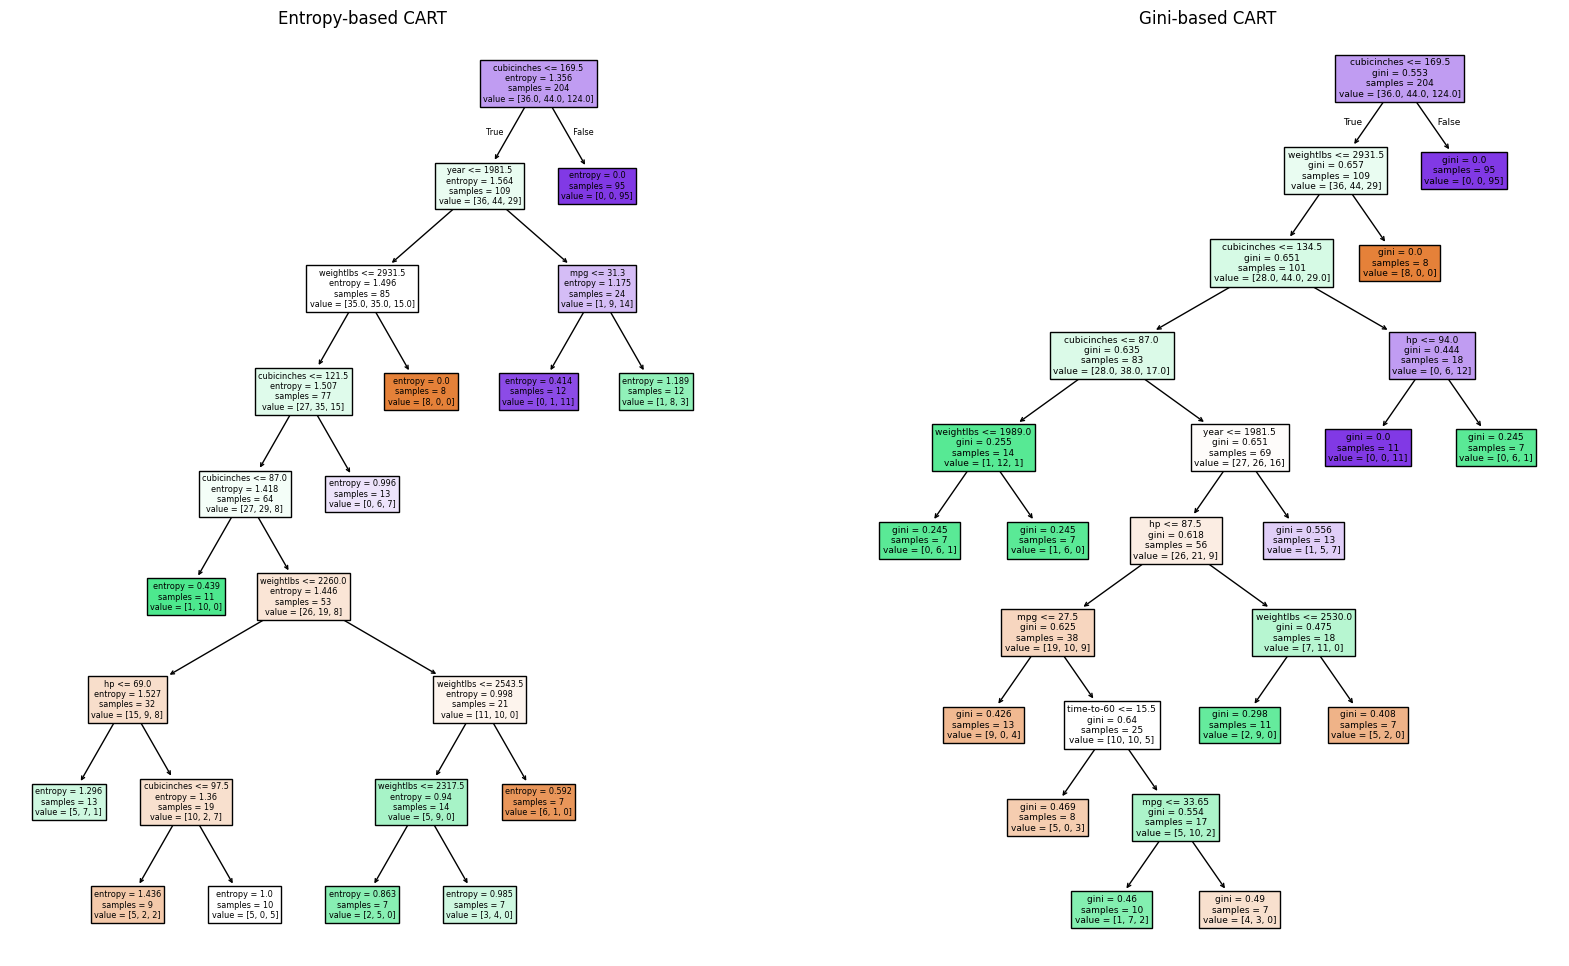

In [82]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth (20)
fig.set_figheight(12)
tree.plot_tree(entropy_classifier, ax=ax1, feature_names=fnames, filled=True)
tree.plot_tree(gini_classifier   , ax=ax2, feature_names=fnames, filled=True)
ax1.set_title('Entropy-based CART')
ax2.set_title('Gini-based CART')
plt.show()

In [83]:
pd.DataFrame({
    'Criteria' : ['Train Time', 'Train F1', 'Test Time', 'Test F1'],
    'Entropy-based CART' : entropy_stats,
    'Gini-based CART'    : gini_stats
})

,Criteria,Entropy-based CART,Gini-based CART
0,Train Time,0.002297,0.008069
1,Train F1,0.838235,0.872549
2,Test Time,0.000260,0.000661
3,Test F1,0.788462,0.807692


**TODO: Analyze the results**

1. Compare the two trees' structures (depth, leafs number, position of leafs)
1. Justify the training time based on the algorithms and trees structures
1. Justify the test time based on the algorithms and trees structures

**Answers**

1. comparaison <br>
Entropy-based tree <br>
    Depth: 8<br>
    Number of leafs: 12<br>
    Position of leafs: not well distributed across the depth<br>
Gini-based tree<br>
    Depth: 9<br>
    Number of leafs: 13<br>
    Position of leafs: well distributed across the depth<br>
1. Gini-based algo takess longer to train because it has a deeper tree and more leafs than the Entropy-based one.The algorithm needs to evaluate more splits and nodes. Decision tree training has a complexity of (O(n \log n)) for sorting the data at each node, where (n) is the number of samples.
1. Gini-based algo takess longer to test because Testing a decision tree has a complexity of (O(d)), where (d) is the depth of the tree, as it involves traversing from the root to a leaf node. The deeper the tree, the longer it takes to traverse from the root to a leaf node during prediction.

#### II.1.2. Maximum depth

We want to test the effect of stopping creteria "maximum depth", so we used F1 score as classification quality measure.

For each maximum depth, we trained a decision/random forest tree and calculated its F1 score on training data (to test convergence) and on test data (to test generalization).

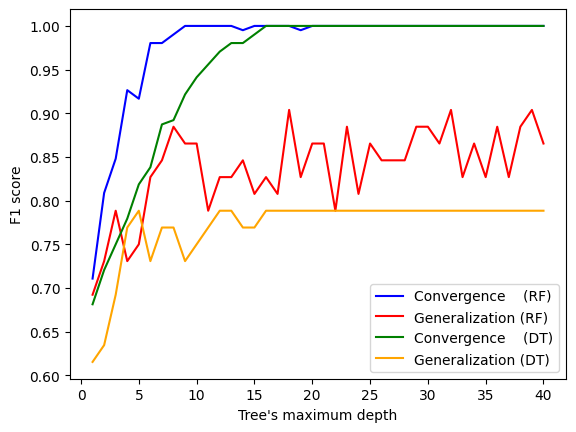

In [84]:
MAX_DEPTH     = 40
MAX_DEPTH_lst = range(1, MAX_DEPTH+1, 1)

f1_trn_md_DT  = []
f1_tst_md_DT  = []
f1_trn_md_RF  = []
f1_tst_md_RF  = []
for max_depth in MAX_DEPTH_lst:
    mdl_DT = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
    mdl_DT.fit(X_cars_train, Y_cars_train)
    f1_trn_md_DT.append(f1_score(Y_cars_train, mdl_DT.predict(X_cars_train), average='micro'))
    f1_tst_md_DT.append(f1_score(Y_cars_test , mdl_DT.predict(X_cars_test) , average='micro'))

    mdl_RF = RandomForestClassifier(n_estimators=30, max_depth=max_depth)
    mdl_RF.fit(X_cars_train, Y_cars_train)
    f1_trn_md_RF.append(f1_score(Y_cars_train, mdl_RF.predict(X_cars_train), average='micro'))
    f1_tst_md_RF.append (f1_score(Y_cars_test , mdl_RF.predict(X_cars_test) , average='micro'))


plt.plot(MAX_DEPTH_lst, f1_trn_md_RF, color='blue'  , label='Convergence    (RF)')
plt.plot(MAX_DEPTH_lst, f1_tst_md_RF, color='red'   , label='Generalization (RF)')
plt.plot(MAX_DEPTH_lst, f1_trn_md_DT, color='green' , label='Convergence    (DT)')
plt.plot(MAX_DEPTH_lst, f1_tst_md_DT, color='orange', label='Generalization (DT)')
plt.ylabel('F1 score')
plt.xlabel('Tree\'s maximum depth')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**

1. Why F1 score (convergence) is not enhanced after depth=17 in decision trees (DT)?
1. Why F1 score (generalization) is not enhanced after depth=17 in decision trees (DT)?
1. Why Random forests (RF) converge better then decision trees (DT) with less maximum depth? 
1. Why Random forests (RF) generalize better then decision trees (DT)? 

**Answers**

1. At a depth of 17, the decision tree has likely captured most of the information within the training data. Going deeper doesn’t enhances the F1 score, as the model has already achieved near-perfect fit to the training data.
1. The generalization F1 score on the decision tree is not enhanced aftre depth 17 because the model begins to overfit the training data and loses its ability to perform well on new data.
1. Random forests converge faster and achieve a higher F1 score with shallower depths due to the ensemble approach. Random forests are an ensemble method that combines multiple decision trees to make predictions. Each tree in the forest is trained on a random subset of the data and features, which helps to reduce variance. 
1. Random forests are an ensemble method that combines multiple decision trees to make predictions, each tree has only a portion of the training data which helps to reduce overfitting and minimize errors.

#### II.1.3. Minimum leaf samples

We want to test the effect of stopping creteria "mimimum samples in leafs", so we used F1 score as classification quality measure.

For each minimum leaf samples number, we trained a decision tree/random forest and calculated its F1 score on training data (to test convergence) and on test data (to test generalization).

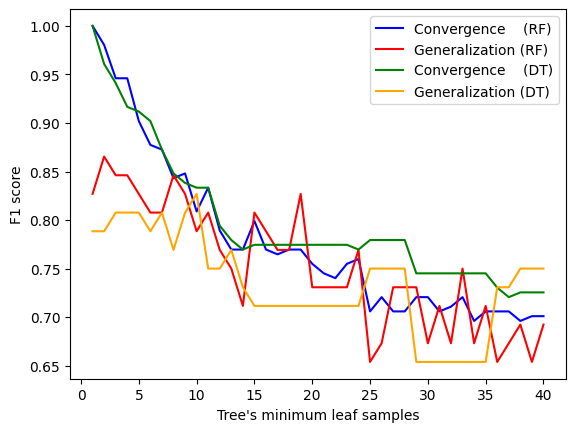

In [85]:
MIN_LEAF    = 40
MIN_LEAF_lst = range(1, MIN_LEAF+1, 1)

f1_trn_ml_DT = []
f1_tst_ml_DT = []
f1_trn_ml_RF = []
f1_tst_ml_RF = []
for min_samples_leaf in MIN_LEAF_lst:
    mdl_DT = DecisionTreeClassifier(random_state=0, min_samples_leaf=min_samples_leaf)
    mdl_DT.fit(X_cars_train, Y_cars_train)
    f1_trn_ml_DT.append(f1_score(Y_cars_train, mdl_DT.predict(X_cars_train), average='micro'))
    f1_tst_ml_DT.append(f1_score(Y_cars_test , mdl_DT.predict(X_cars_test) , average='micro'))

    mdl_RF = RandomForestClassifier(n_estimators=30, min_samples_leaf=min_samples_leaf)
    mdl_RF.fit(X_cars_train, Y_cars_train)
    f1_trn_ml_RF.append(f1_score(Y_cars_train, mdl_RF.predict(X_cars_train), average='micro'))
    f1_tst_ml_RF.append(f1_score(Y_cars_test , mdl_RF.predict(X_cars_test) , average='micro'))


plt.plot(MIN_LEAF_lst, f1_trn_ml_RF, color='blue'  , label='Convergence    (RF)')
plt.plot(MIN_LEAF_lst, f1_tst_ml_RF, color='red'   , label='Generalization (RF)')
plt.plot(MIN_LEAF_lst, f1_trn_ml_DT, color='green' , label='Convergence    (DT)')
plt.plot(MIN_LEAF_lst, f1_tst_ml_DT, color='orange', label='Generalization (DT)')
plt.ylabel('F1 score')
plt.xlabel('Tree\'s minimum leaf samples')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why F1 score of decision trees (DT) gets worst when increasing the minimum leaf samples?
1. Why F1 score of decision trees (DT) gets better then random forests when increasing the minimum leaf samples?

**Answers**

1. The tree will have fewer splits and will be less capable of capturing the finer details of the training data. As a result, the model may underfit the data, leading to a decrease in the F1 score
1. As the minimum leaf samples increase, the decision tree becomes more generalized and less prone to overfitting. But as the RF is already generalize it will be underfitted.


### II.2. Ensemle Learning

Random forests are just bagging over decision trees. 
We want to test different hyper-parameters of ensemble learning.

#### II.2.1. Estimators' number

We want to test the effect of estimators' number in both AdaBoost and Bagging. 
We applied these two ensemble learning techniques on decision trees and logistic regression.

In [86]:
MAX_ESTIMATORS     = 50
MAX_ESTIMATORS_lst = range(1, MAX_ESTIMATORS+1, 1)

mdls = [
    ('Logistic Regression', LogisticRegression(solver='liblinear')), 
    ('Decision Tree', DecisionTreeClassifier(random_state=0))
]

mdls_perf = {}
for mdl_name, mdl in mdls:
    mdls_perf[mdl_name] = {'bagging': [], 'boosting': []}

for n_estimators in MAX_ESTIMATORS_lst:
    for mdl_name, mdl in mdls:
        mdl_bagging  = BaggingClassifier (estimator=mdl, n_estimators=n_estimators)
        mdl_boosting = AdaBoostClassifier(estimator=mdl, n_estimators=n_estimators, algorithm='SAMME')

        mdl_bagging.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_bagging.predict(X_cars_test)
        mdls_perf[mdl_name]['bagging'].append(accuracy_score(Y_cars_test, Y_pred))


        mdl_boosting.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_boosting.predict(X_cars_test)
        mdls_perf[mdl_name]['boosting'].append(accuracy_score(Y_cars_test, Y_pred))

print('DONE')

DONE


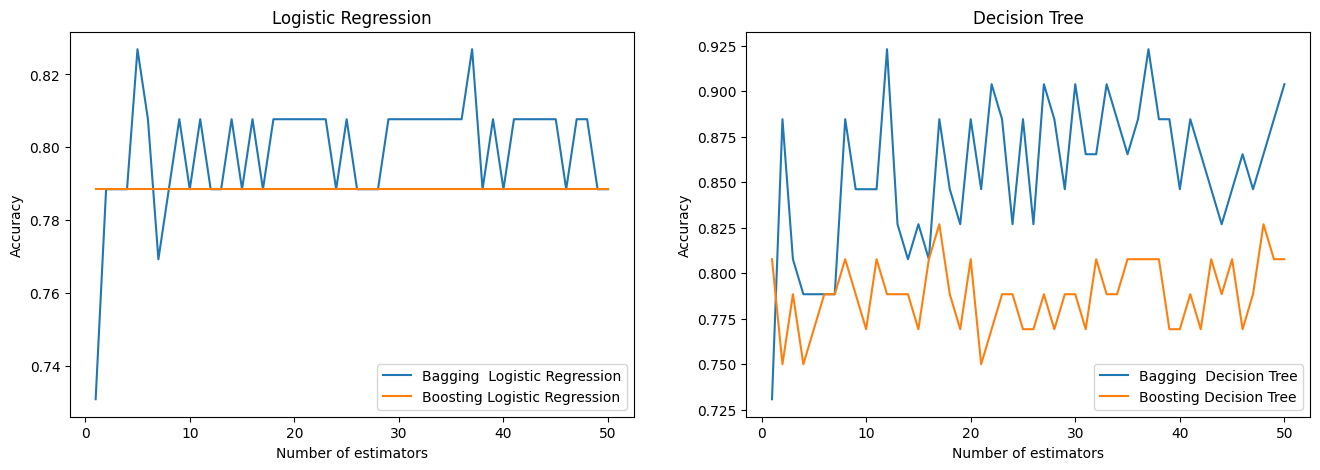

In [87]:
fig, axs = plt.subplots(1, len(mdls), figsize=(16,5))

for i, (mdl_name, mdl) in enumerate(mdls):
    axs[i].plot(MAX_ESTIMATORS_lst, mdls_perf[mdl_name]['bagging' ], label='Bagging  ' + mdl_name)
    axs[i].plot(MAX_ESTIMATORS_lst, mdls_perf[mdl_name]['boosting'], label='Boosting ' + mdl_name)

    axs[i].set_ylabel('Accuracy')
    axs[i].set_xlabel('Number of estimators')
    axs[i].set_title(mdl_name)
    axs[i].legend()


# plt.ylabel('Accuracy')
# plt.xlabel('Number of estimators')
# plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why Bagging is better than boosting in this experiment (according to the data)?
1. Propose a logical hypothesis to why Logistic Regression does not improve using boosting.
1. Why bagging is enhancing accuracy using decision trees?
1. Why boosting is not enhancing accuracy as much as bagging using decision trees?

**Answers**

1. Our data has a high variance and noise and outliers. Bagging leads to a more stable model that avoids overfitting and reducing variance,as it reduces variance by creating multiple independent models trained on different subsets of the data and averaging their predictions. In contrast, boosting focuses on iteratively improving the model by giving more weight to misclassified instances, which can lead to overfitting (noise and outliers) and increased bias.
1. Boosting works best with models that has more flexibility and can adapt to errors from previous iterations, but logistic regression does not benefit  from this iterative process because it is already a linear robust model that can not capture complex non-linear patterns effectively.
1. Decision Trees are highly sensitive to changes in the training data, so Bagging helps by training multiple trees on different random subsets of the data and averaging their predictions and reducing their variance.
1. In decision trees, boosting focuses on difficult-to-classify problems, itaims to correct the errors of previous models sequentially, which can  lead to overfitting, especially if the dataset contains noise or outliers. In contrast, bagging averages out predictions from multiple independent models, which tends to improve generalization without the risk of overfitting.

#### II.2.2. Bootstrap's size

In this expreiment, we are interested in bagging; more precisely, Bootstrap's size.

*P.S. We used SGD instead of linear logistic regression because this latter has some problems with bagging*

In [88]:
BAG_PERC_lst = np.arange(0.1, 1, 0.01)

mdls_bag = [
    ('Logistic Regression', SGDClassifier()),
    # ('Logistic Regression', LogisticRegression(solver='liblinear')), 
    ('Decision Tree', DecisionTreeClassifier(random_state=0))
]

mdls_bag_perf = {}
for mdl_name, mdl in mdls_bag:
    mdls_bag_perf[mdl_name] = {'train': [], 'test': []}

for max_samples in BAG_PERC_lst:
    for mdl_name, mdl in mdls_bag:
        mdl_bagging  = BaggingClassifier (estimator=mdl, n_estimators=20, max_samples=max_samples)

        mdl_bagging.fit(X_cars_train, Y_cars_train)
        Y_pred = mdl_bagging.predict(X_cars_train)
        mdls_bag_perf[mdl_name]['train'].append(accuracy_score(Y_cars_train, Y_pred))

        Y_pred = mdl_bagging.predict(X_cars_test)
        mdls_bag_perf[mdl_name]['test'].append(accuracy_score(Y_cars_test, Y_pred))

print('DONE')

DONE


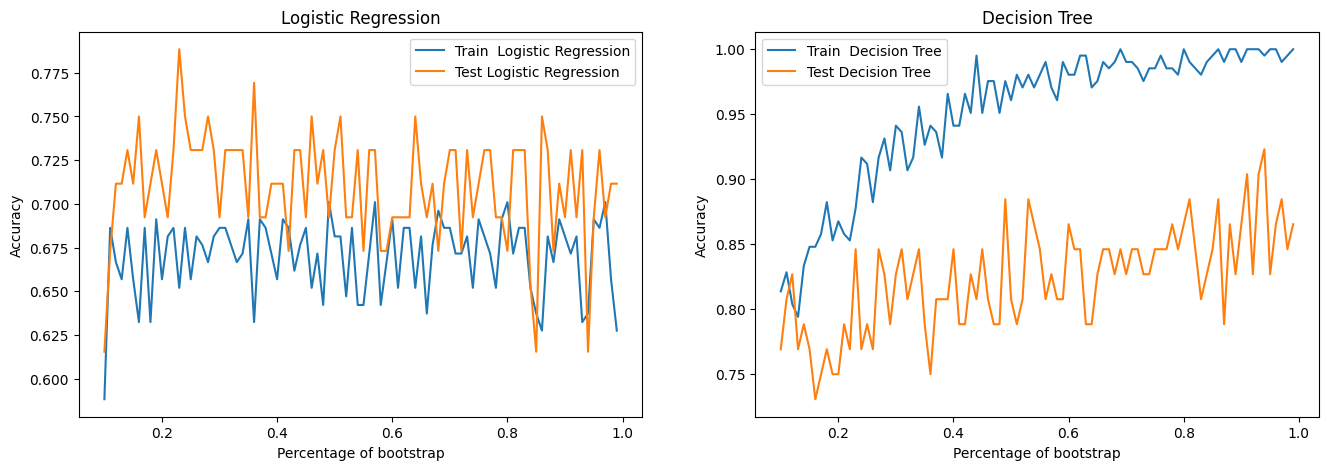

In [89]:
fig, axs = plt.subplots(1, len(mdls_bag), figsize=(16,5))

for i, (mdl_name, mdl) in enumerate(mdls_bag):
    axs[i].plot(BAG_PERC_lst, mdls_bag_perf[mdl_name]['train' ], label='Train  ' + mdl_name)
    axs[i].plot(BAG_PERC_lst, mdls_bag_perf[mdl_name]['test']  , label='Test '   + mdl_name)

    axs[i].set_ylabel('Accuracy')
    axs[i].set_xlabel('Percentage of bootstrap')
    axs[i].set_title(mdl_name)
    axs[i].legend()


# plt.ylabel('Accuracy')
# plt.xlabel('Number of estimators')
# plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO: Analyze the results**
1. Why the accuracy's cruve is not smooth?
1. Why increasing the size of a bootstrap increases the accuracy in case of decision trees?
1. Why it does not in case of logistic regression?

**Answers**

1. The accuracy curves is due to the random nature of bootstrap sampling. Each time the data is sampled to create different bootstrap sets, variations in the training data can lead to changes in the model's performance.
1. Decision trees benefit from larger training sets because they provide the model with more data during training and they tend to overfit on small datasets, that is why they can capture more patterns and reduce variance.
1. Logistic regression is a linear model, it has a limited capacity to learn complex relationships, which makes it less prone to overfitting compared to decision trees, especially with small datasets. 

In [90]:
print('Trees and forests are crucial for life on earth')
print('Not these trees though :)')

Trees and forests are crucial for life on earth
Not these trees though :)
